## CC3092 - Deep Learning y Sistemas Inteligentes  
## Hoja de Trabajo 2  
### Semestre II - 2025  

**Integrantes:**  
- Sofía Mishell Velásquez, 22049  
- José Rodrigo Marchena, 22398  
- José Joaquín Campos, 22115  
---

# Ejercicio 1 - Experimentación Práctica

## Task 1 - Preparación del conjunto de datos
En esta sección se carga el conjunto de datos Iris utilizando `sklearn.datasets`. Posteriormente, se dividen los datos en entrenamiento y validación para asegurar que los modelos se prueben adecuadamente en datos no vistos.

In [4]:
# Task 1 - Preparación del conjunto de datos
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader

# Cargar dataset Iris
iris = load_iris()
X, y = iris.data, iris.target

# Normalización
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Separación en train/val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Conversión a tensores
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_val_t   = torch.tensor(X_val, dtype=torch.float32)
y_val_t   = torch.tensor(y_val, dtype=torch.long)

# Crear DataLoaders
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=16, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=16, shuffle=False)

c:\Users\JM\miniconda3\envs\torch19\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Task 2 - Arquitectura modelo
Aquí se construye una red neuronal feedforward simple con nn.Module.
La red incluye una capa de entrada, capas ocultas y una capa de salida con número de neuronas igual al número de clases en Iris (3).

In [5]:
# Task 2 - Arquitectura del modelo
import torch.nn as nn

class IrisNet(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=16, output_dim=3):
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

# Instanciar modelo
model = IrisNet()
print(model)

IrisNet(
  (fc1): Linear(in_features=4, out_features=16, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=3, bias=True)
)


## Task 3 - Funciones de Pérdida
El objetivo es comparar el rendimiento del modelo utilizando distintas funciones de pérdida.
Se probarán al menos tres pérdidas comunes:
- nn.CrossEntropyLoss (adecuada para clasificación multiclase)
- nn.MSELoss (Mean Squared Error)
- nn.NLLLoss (Negative Log Likelihood, usando LogSoftmax)

In [6]:
# Task 3 - Funciones de Pérdida
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Diccionario de funciones de pérdida
loss_functions = {
    "cross_entropy": nn.CrossEntropyLoss(),
    "mse": nn.MSELoss(),
    "nll": nn.NLLLoss()
}

# Entrenamiento parametrizable
def train_model(loss_name="cross_entropy", use_l1=False, use_l2=False, epochs=50):
    model = IrisNet()
    
    # Selección de función de pérdida
    if loss_name == "nll":
        criterion = loss_functions["nll"]
        model_output = nn.LogSoftmax(dim=1)
    else:
        criterion = loss_functions[loss_name]
        model_output = lambda x: x  # salida directa
    
    # Optimizador con L2 si se requiere
    optimizer = optim.Adam(model.parameters(), lr=0.01,
                           weight_decay=1e-4 if use_l2 else 0.0)
    
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            outputs = model_output(model(xb))
            
            # MSE requiere one-hot encoding
            if loss_name == "mse":
                yb_onehot = F.one_hot(yb, num_classes=3).float()
                loss = criterion(outputs, yb_onehot)
            else:
                loss = criterion(outputs, yb)
            
            # Penalización L1
            if use_l1:
                l1_penalty = sum(param.abs().sum() for param in model.parameters())
                loss += 1e-4 * l1_penalty

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Validación
        model.eval()
        with torch.no_grad():
            val_losses = []
            for xb, yb in val_loader:
                val_out = model_output(model(xb))
                if loss_name == "mse":
                    yb_onehot = F.one_hot(yb, num_classes=3).float()
                    val_loss = criterion(val_out, yb_onehot)
                else:
                    val_loss = criterion(val_out, yb)
                val_losses.append(val_loss.item())
        
        if (epoch+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] "
                  f"| Train Loss: {loss.item():.4f} "
                  f"| Val Loss: {sum(val_losses)/len(val_losses):.4f}")
    
    return model

# Ejemplos de entrenamiento con diferentes funciones de pérdida
print("== Entrenando con CrossEntropy ==")
train_model("cross_entropy")

print("\n== Entrenando con MSE ==")
train_model("mse")

print("\n== Entrenando con NLL ==")
train_model("nll")


== Entrenando con CrossEntropy ==
Epoch [10/50] | Train Loss: 0.0175 | Val Loss: 0.1029
Epoch [20/50] | Train Loss: 0.2203 | Val Loss: 0.1137
Epoch [30/50] | Train Loss: 0.0018 | Val Loss: 0.0911
Epoch [40/50] | Train Loss: 0.0005 | Val Loss: 0.0944
Epoch [50/50] | Train Loss: 0.0301 | Val Loss: 0.1093

== Entrenando con MSE ==
Epoch [10/50] | Train Loss: 0.0064 | Val Loss: 0.0324
Epoch [20/50] | Train Loss: 0.0158 | Val Loss: 0.0264
Epoch [30/50] | Train Loss: 0.0217 | Val Loss: 0.0248
Epoch [40/50] | Train Loss: 0.0072 | Val Loss: 0.0196
Epoch [50/50] | Train Loss: 0.0041 | Val Loss: 0.0182

== Entrenando con NLL ==
Epoch [10/50] | Train Loss: 0.0223 | Val Loss: 0.0899
Epoch [20/50] | Train Loss: 0.0172 | Val Loss: 0.0845
Epoch [30/50] | Train Loss: 0.0030 | Val Loss: 0.0565
Epoch [40/50] | Train Loss: 0.0495 | Val Loss: 0.0563
Epoch [50/50] | Train Loss: 0.3004 | Val Loss: 0.0603


IrisNet(
  (fc1): Linear(in_features=4, out_features=16, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=3, bias=True)
)

## Task 4 - Funciones de Pérdida

Parametrizar el uso de diferentes tecnicas de regularacion
- L1 -> custom
- L2 -> torch.optim.Adam(.. weight_decay = <L2_lambda>)
- Dropout -> nn.Dropout()

In [10]:

class IrisNetReg(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=16, output_dim=3, dropout=0):
        super(IrisNetReg, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

# L1
L1_lambda = 1e-4
def L1_reg(model):
    l1_norm = sum(
        p.abs().sum()
     for p in model.parameters())
    return L1_lambda * l1_norm

def train_model_reg(do_L1=False, do_L2=False, dropout=0, epochs=50):
    # Dropout
    model = IrisNetReg(dropout=dropout)
    optimizer = optim.Adam(
        model.parameters(), lr=0.01,
        weight_decay=1e-4 if do_L2 else 0.0 # L2
    )
    criterion = nn.CrossEntropyLoss()
    model_output = lambda x: x 
    
    # Train loop
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            outputs = model_output(model(xb))
            loss = criterion(outputs, yb)
            if (do_L1): # L1
                loss+=L1_reg(model)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Validación
        model.eval()
        with torch.no_grad():
            val_losses = []
            for xb, yb in val_loader:
                val_out = model_output(model(xb))
                val_loss = criterion(val_out, yb)
                val_losses.append(val_loss.item())
        if (epoch+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] "
                  f"| Train Loss: {loss.item():.4f} "
                  f"| Val Loss: {sum(val_losses)/len(val_losses):.4f}")
    
    return model

print("== Entrenando sin Regularizacion ==")
train_model_reg()
print("== Entrenando con L1 ==")
train_model_reg(do_L1=True)
print("== Entrenando con L2 ==")
train_model_reg(do_L2=True)
print("== Entrenando con Dropout 50% ==")
train_model_reg(dropout=0.5)


== Entrenando sin Regularizacion ==
Epoch [10/50] | Train Loss: 0.0055 | Val Loss: 0.0849
Epoch [20/50] | Train Loss: 0.0112 | Val Loss: 0.0672
Epoch [30/50] | Train Loss: 0.0255 | Val Loss: 0.0890
Epoch [40/50] | Train Loss: 0.0161 | Val Loss: 0.0983
Epoch [50/50] | Train Loss: 0.0151 | Val Loss: 0.0766
== Entrenando con L1 ==
Epoch [10/50] | Train Loss: 0.1472 | Val Loss: 0.0880
Epoch [20/50] | Train Loss: 0.0225 | Val Loss: 0.0635
Epoch [30/50] | Train Loss: 0.0243 | Val Loss: 0.0583
Epoch [40/50] | Train Loss: 0.0146 | Val Loss: 0.0534
Epoch [50/50] | Train Loss: 0.0161 | Val Loss: 0.0538
== Entrenando con L2 ==
Epoch [10/50] | Train Loss: 0.2341 | Val Loss: 0.1137
Epoch [20/50] | Train Loss: 0.0229 | Val Loss: 0.0681
Epoch [30/50] | Train Loss: 0.0011 | Val Loss: 0.0727
Epoch [40/50] | Train Loss: 0.0097 | Val Loss: 0.0789
Epoch [50/50] | Train Loss: 0.0340 | Val Loss: 0.0868
== Entrenando con Dropout 50% ==
Epoch [10/50] | Train Loss: 0.1505 | Val Loss: 0.1154
Epoch [20/50] | Tra

IrisNetReg(
  (fc1): Linear(in_features=4, out_features=16, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=3, bias=True)
)

## Task 5 - Algoritmos de Optimización

Parametrizar el uso de tecnicas de optimizacion
- SDG
- Batch GD
- Mini-Batch GD

In [ ]:
import time


def train_with_opt(batch_size=1, opt_func='adam',epochs=50):

    model = IrisNet()
    
    train_loader_b = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
    val_loader_b   = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=batch_size, shuffle=False)
    criterion = nn.CrossEntropyLoss()
    model_output = lambda x:x
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    start = time.time()
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            outputs = model_output(model(xb))
            loss = criterion(outputs, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Validación
        model.eval()
        with torch.no_grad():
            val_losses = []
            for xb, yb in val_loader:
                val_out = model_output(model(xb))
                val_loss = criterion(val_out, yb)
                val_losses.append(val_loss.item())
        if (epoch+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] "
                  f"| Train Loss: {loss.item():.4f} "
                  f"| Val Loss: {sum(val_losses)/len(val_losses):.4f}")
    
    print(f"Training time: {time.time()-start:.3f} s")
    return model


print("== Entrenando: Mini-Batch GD ==")
train_with_opt(batch_size=16)
print("\n== Entrenando: Batch GD ==") 
train_with_opt(batch_size=120) # 120 es el tamaño del dataset
print("\n== Entrenando: SGD ==")
train_with_opt(batch_size=1)
    

== Entrenando: Mini-Batch GD ==
Epoch [10/50] | Train Loss: 0.6933 | Val Loss: 0.7558
Epoch [20/50] | Train Loss: 0.4287 | Val Loss: 0.4613
Epoch [30/50] | Train Loss: 0.3343 | Val Loss: 0.3434
Epoch [40/50] | Train Loss: 0.1394 | Val Loss: 0.2728
Epoch [50/50] | Train Loss: 0.0564 | Val Loss: 0.2118
Training time: 0.523 s

== Entrenando: Batch GD ==
Epoch [10/50] | Train Loss: 0.8120 | Val Loss: 0.7943
Epoch [20/50] | Train Loss: 0.3091 | Val Loss: 0.4405
Epoch [30/50] | Train Loss: 0.0931 | Val Loss: 0.3101
Epoch [40/50] | Train Loss: 0.1939 | Val Loss: 0.2315
Epoch [50/50] | Train Loss: 0.2312 | Val Loss: 0.1751
Training time: 0.428 s

== Entrenando: SGD ==
Epoch [10/50] | Train Loss: 0.8407 | Val Loss: 0.7918
Epoch [20/50] | Train Loss: 0.3184 | Val Loss: 0.4069
Epoch [30/50] | Train Loss: 0.1394 | Val Loss: 0.2704
Epoch [40/50] | Train Loss: 0.0984 | Val Loss: 0.1818
Epoch [50/50] | Train Loss: 0.0634 | Val Loss: 0.1319
Training time: 0.491 s


IrisNet(
  (fc1): Linear(in_features=4, out_features=16, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=3, bias=True)
)

## Task 6 - Experimentación y Análisis

Entrene los modelos con diferentes combinaciones de funciones de pérdida, técnicas de regularización y algoritmos
de optimización. Para no complicar esta parte, puede dejar fijo dos de estos parámetros (función de pérdida, técnnicas de regularización, algoritmo de optimización) y solamente cambiar uno de ellos. Deben verse al menos 9
combinaciones en total, donde es válido que en una de ellas no haya ninguna técnica de regularización. Si quiere
experimentar con más combinaciones se le dará hasta 10% de puntos extra.
Para cada combinación registre métricas como precisión, pérdida y alguna otra métrica que considere pertinente
(Recuerde lo visto en inteligencia artificial).
Visualice las curvas (tanto en precisión, pérdida y la tercera métrica que decidió) de entrenamiento y validación
utilizando bibliotecas como matplotlib y/o seaborn. Además, recuerde llevar tracking de los tiempos de ejecución de
cada combinación.

Solo se variara la regularacion dadas los siguientes parametros
- Regularizacion (variante): 
  - L1: [0, 1e-4], 
  - L2: [0, 1e-4], 
  - Dropout: [0, 0.2, 0.5]



In [66]:
import itertools
from sklearn.metrics import precision_score

def train_model_gs(params, epochs=50):
    # Get params
    L1 = params["L1_lambda"]
    L2 = params["L2_lambda"]
    dropout = params["Dropout"]
    
    # Dropout
    model = IrisNetReg(dropout=dropout)
    optimizer = optim.Adam(
        model.parameters(), lr=0.01,
        weight_decay=L2 # L2
    )
    criterion = nn.CrossEntropyLoss()
    model_output = lambda x: x 
    logs = []
    
    # Train loop
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            outputs = model_output(model(xb))
            loss = criterion(outputs, yb)
            if (L1>0): # L1
                loss+=L1_reg(model)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Validación
        model.eval()
        with torch.no_grad():
            val_losses = []
            all_preds = []
            all_labels = []
            for xb, yb in val_loader:
                val_out = model_output(model(xb))
                val_loss = criterion(val_out, yb)
                val_losses.append(val_loss.item())
                
                preds = torch.argmax(val_out, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(yb.cpu().numpy())
            
            all_preds = torch.tensor(all_preds)
            all_labels = torch.tensor(all_labels)
        if (epoch+1) % 5 == 0:
            logs.append({
                "epoch": epoch+1, 
                "train_loss": loss.item(),
                "val_loss": sum(val_losses)/len(val_losses),
                "precision": precision_score(all_labels, all_preds, average="macro")
                })
    
    return logs



In [93]:
## Grid Search
import time
reg_parameters = {
    "L1_lambda": [0, 1e-4],
    "L2_lambda": [0, 1e-4],
    "Dropout": [0, 0.25, 0.5]
}

keys = reg_parameters.keys()
values = reg_parameters.values()

results = []
for combo in itertools.product(*values):
    params = dict(zip(keys, combo))
    start = time.time()
    train_rslt = train_model_gs(params, epochs=50)
    results.append({
        str(params): {
            "train_rslts": train_rslt,
            "time": (time.time() - start)
        }
    })

print(len(results))

12


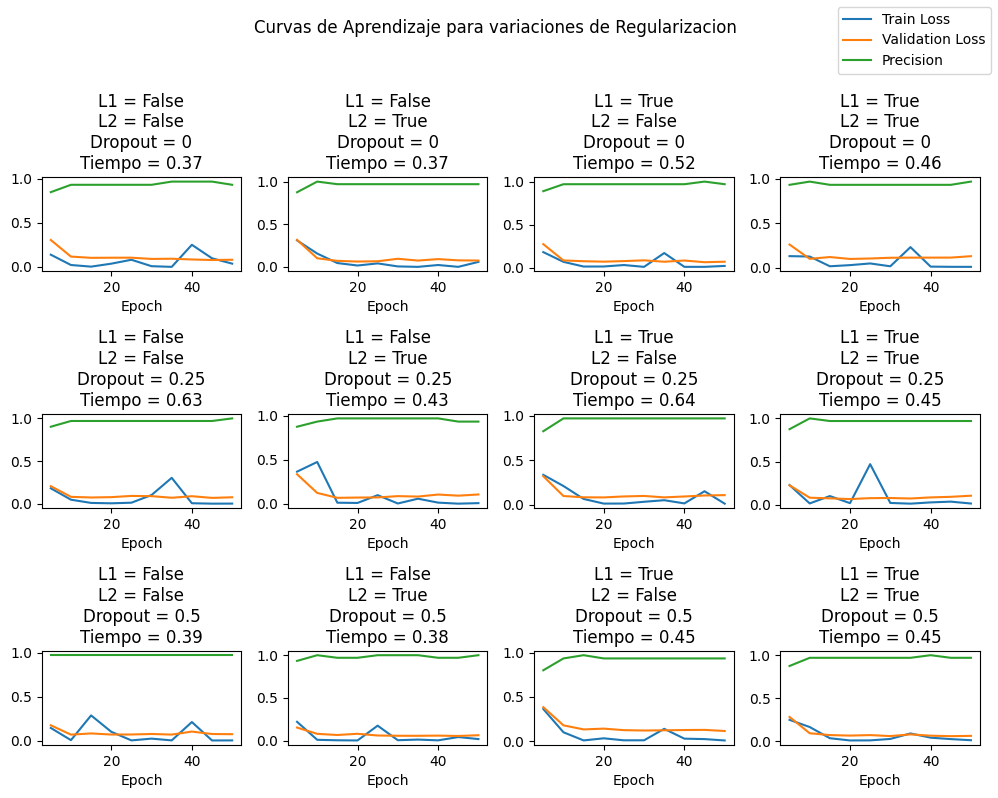

In [113]:
from matplotlib import pyplot as plt
import pandas as pd
import ast

fig, ax = plt.subplots(3, 4, figsize =(10, 8))
fig.suptitle("Curvas de Aprendizaje para variaciones de Regularizacion\n\n")
for n, rs in enumerate(results):
    name = list(rs.keys())[0]
    name_dict = ast.literal_eval(name)
    L1_ ="True" if name_dict["L1_lambda"] > 0 else "False" 
    L2_ = "True" if name_dict["L2_lambda"] > 0 else "False" 
    dropout_ = name_dict["Dropout"]
    time_ = rs[name]["time"]
    info_df =pd.DataFrame(rs[name]["train_rslts"])
    ax[n%3][n//3].set_title(
        f"L1 = {L1_}\nL2 = {L2_}\nDropout = {dropout_}\nTiempo = {time_:.2f}"
    )
    ax[n%3][n//3].plot(info_df["epoch"], info_df["train_loss"], label="Train Loss")
    ax[n%3][n//3].plot(info_df["epoch"], info_df["val_loss"], label="Validation Loss")
    ax[n%3][n//3].plot(info_df["epoch"], info_df["precision"], label="Precision")
    ax[n%3][n//3].set_xlabel("Epoch")
    fig.tight_layout()

handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")


plt.tight_layout()
plt.show()
    